This notebook is just meant to test the codes before I compile them as .py files.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.io.ascii as astropy_ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from src.utils.constants import *

from scipy.stats import norm
from scipy.optimize import curve_fit

GOLDEN_RATIO = 0.5*(1+np.sqrt(5))
FIGURE_HEIGHT = 5
FIGURE_WIDTH = FIGURE_HEIGHT*GOLDEN_RATIO
DEFAULT_FIGSIZE = (FIGURE_WIDTH, FIGURE_HEIGHT)

# 1. Fetch coordinates (ra, dec) from raw data

In [ ]:
# 6dFGS
df = pd.read_csv('data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)

# ra is still in hour -> need to convert to degrees
df_test = df[['ra', 'dec']]

In [ ]:
Table.from_pandas(df_test).write('6dfgs_coord.ascii', format='ipac', overwrite=True)

In [ ]:
# LAMOST
with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df = pd.DataFrame(hdul[1].data)

df[['ra', 'dec']].describe()

In [ ]:
# # sdss
# df = pd.read_csv('data/raw/sdss/SDSS_spectro_mrafifrbbn.csv')

# df[['ra', 'dec']].describe()

# 2. Merge the spectroscopy and photometry

In [ ]:
# Compare the original raw data to 2MASS (check if the order is the same)
with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df_lamost_spectro = pd.DataFrame(hdul[1].data)
    
df_lamost_tmass = pd.read_csv('data/raw/2mass/lamost_tmass.csv', low_memory=False)

df = pd.merge(df_lamost_spectro[['ra', 'dec']], df_lamost_tmass[['ra_01', 'dec_01']], left_index=True, right_index=True)

df['delta_ra'] = df['ra_01']-df['ra']
df['delta_dec'] = df['dec_01']-df['dec']


df[['delta_ra', 'delta_dec']].describe()

In [ ]:
# Compare the original raw data to 2MASS
df_6df_spectro = pd.read_csv('data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)
df_6df_spectro['ra'] = df_6df_spectro['ra']*15

df_6df_tmass = pd.read_csv('data/raw/2mass/6dfgs_tmass.csv', low_memory=False)

df = pd.merge(df_6df_spectro[['ra', 'dec']], df_6df_tmass[['ra_01', 'dec_01']], left_index=True, right_index=True)

df['delta_ra'] = df['ra_01']-df['ra']
df['delta_dec'] = df['dec_01']-df['dec']

df[['delta_ra', 'delta_dec']].describe()

# Coba2 cross-matching

In [ ]:
# LAMOST
with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df_lamost = Table(hdul[1].data).to_pandas()

df_sdss = pd.read_csv('data/raw/sdss/SDSS_spectro_mrafifrbbn.csv')

In [ ]:
sdss_coords = SkyCoord(ra=df_sdss['ra'].to_numpy()*u.deg, dec=df_sdss['dec'].to_numpy()*u.deg)
lamost_coords = SkyCoord(ra=df_lamost['ra'].to_numpy()*u.deg, dec=df_lamost['dec'].to_numpy()*u.deg)

In [ ]:
idx, sep2d, _ = lamost_coords.match_to_catalog_sky(sdss_coords)
is_counterpart = sep2d < 1.*u.arcsec

df_lamost['sdss_idx'] = idx
df_lamost['sdss_counterpart'] = is_counterpart

df_lamost = df_lamost[df_lamost['sdss_counterpart']==True]

In [ ]:
df_lamost_sdss = df_lamost.merge(df_sdss, left_on='sdss_idx', right_index=True)

In [ ]:
df_lamost_sdss[['ra_x', 'dec_x', 'ra_y', 'dec_y', 'veldisp_x', 'sigmaStars']]

## Main code for merging

### 6dFGS: Combine Vizier data (what I used throughout my thesis)

In [ ]:
# FP data
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_fp = Table(hdul[1].data).to_pandas()
    
df_fp.head()

In [ ]:
# veldisp data
with fits.open('data/raw/6dfgs/sdfgs_veldisp_vizier.fits') as hdul:
    df_veldisp = Table(hdul[1].data).to_pandas()

veldisp_columns = ['_6dFGS', 'MJD', 'z', 'S_N', 'R', 'Vd', 'e_Vd', '_RA', '_DE']
df_veldisp = df_veldisp[veldisp_columns]

df_veldisp.head()

In [ ]:
df_6dfgs = df_fp.merge(df_veldisp, on='_6dFGS', how='inner')

df_6dfgs

In [ ]:
df_6df_campbell = pd.read_csv('data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)[['6dFGSid', 'ra', 'dec']]
df_6df_campbell['ra'] = df_6df_campbell['ra']

In [ ]:
df_compare = df_6dfgs.merge(df_6df_campbell, left_on='_6dFGS', right_on='6dFGSid')
df_compare['DELTA_RA'] = (df_compare['RAJ2000']-df_compare['ra'])*15*3600
df_compare['DELTA_DE'] = (df_compare['DEJ2000']-df_compare['dec'])*3600
df_compare[['RAJ2000', 'DEJ2000', 'ra', 'dec', 'DELTA_RA', 'DELTA_DE']]

In [ ]:
# Selidiki perbedaan ra_01 dec_01 (input) dan ra dan dec (dari 2MASS)
df = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')

coords_1 = SkyCoord(ra=df['ra_01'].to_numpy()*u.deg, dec=df['dec_01'].to_numpy()*u.deg)
coords_2 = SkyCoord(ra=df['ra'].to_numpy()*u.deg, dec=df['dec'].to_numpy()*u.deg)

idx, sep2d, _ = coords_1.match_to_catalog_sky(coords_2)

plt.hist(sep2d.arcsec, bins=100)
plt.show()

In [ ]:
# Selidiki perbedaan ra_01 dec_01 dan sup_ra dan sup_dec
df = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')

coords_1 = SkyCoord(ra=df['ra_01'].to_numpy()*u.deg, dec=df['dec_01'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=df['sup_ra'].to_numpy()*u.deg, dec=df['sup_dec'].to_numpy()*u.deg)

idx, sep2d, _ = coords_1.match_to_catalog_sky(coords_sup)

plt.hist(sep2d.arcsec, bins=100)
plt.show()

In [ ]:
max(sep2d.arcsec)

In [ ]:
len(df)

In [ ]:
# Selidiki perbedaan ra dec dan sup_ra dan sup_dec
df = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')

coords_1 = SkyCoord(ra=df['ra'].to_numpy()*u.deg, dec=df['dec'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=df['sup_ra'].to_numpy()*u.deg, dec=df['sup_dec'].to_numpy()*u.deg)

idx, sep2d, _ = coords_1.match_to_catalog_sky(coords_sup)

plt.hist(sep2d.arcsec, bins=100)
plt.show()

##### Eksperimen mau pake ra dec atau sup_ra dan sup_dec (dan berapa threshold yang optimal)

In [ ]:
# Ambil data vizier (11102 galaksi)
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_6df = Table(hdul[1].data).to_pandas()[['_2MASX', 'RAJ2000', 'DEJ2000']]
df_6df['RAJ2000'] *= 15
df_6df['_2MASX'] = '2MASX' + df_6df['_2MASX']
    
# Ambil data 2MASS (11117 galaksi)
df_2mass = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')[['designation', 'ra_01', 'dec_01', 'ra', 'dec', 'sup_ra', 'sup_dec']]
df_2mass['_2MASX'] = '2MASXJ' + df_2mass['designation']

# Find the extra 15 galaxies
dfe = pd.merge(df_2mass, df_6df, how='left', on='_2MASX', indicator=True).query('_merge=="left_only"')

# Store the coordinates
coords_ori = SkyCoord(ra=dfe['ra_01'].to_numpy()*u.deg, dec=dfe['dec_01'].to_numpy()*u.deg)
coords_radec = SkyCoord(ra=dfe['ra'].to_numpy()*u.deg, dec=dfe['dec'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=dfe['sup_ra'].to_numpy()*u.deg, dec=dfe['sup_dec'].to_numpy()*u.deg)

f, (ax1, ax2) = plt.subplots(nrows=2)

# Find the separation between ra_01 dec_01 (original data) with ra dec
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_radec)
print(f'Min sep2d with ra and dec: {min(sep2d.arcsec)}')
print(f'Max sep2d with ra and dec: {max(sep2d.arcsec)}')
ax1.hist(sep2d.arcsec)
ax1.set_title('Sep2d for the extra 15 galaxies with ra and dec')

print('\n')

# Find the separation between ra_01 dec_01 (original data) with sup_ra and sup_dec
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_sup)
print(f'Min sep2d with sup_ra and sup_dec: {min(sep2d.arcsec)}')
print(f'Max sep2d with sup_ra and sup_dec: {max(sep2d.arcsec)}')
ax2.hist(sep2d.arcsec)
ax2.set_title('Sep2d for the extra 15 galaxies with sup_ra and sup_dec')

f.tight_layout()
plt.show()

In [ ]:
# Find the common 11102 galaxies
dfe = pd.merge(df_2mass, df_6df, how='left', on='_2MASX', indicator=True).query('_merge=="both"')

# Store the coordinates
coords_ori = SkyCoord(ra=dfe['ra_01'].to_numpy()*u.deg, dec=dfe['dec_01'].to_numpy()*u.deg)
coords_radec = SkyCoord(ra=dfe['ra'].to_numpy()*u.deg, dec=dfe['dec'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=dfe['sup_ra'].to_numpy()*u.deg, dec=dfe['sup_dec'].to_numpy()*u.deg)

f, (ax1, ax2) = plt.subplots(nrows=2)

# Find the separation between ra_01 dec_01 (original data) with ra dec
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_radec)
print(f'Min sep2d with ra and dec: {min(sep2d.arcsec)}')
print(f'Max sep2d with ra and dec: {max(sep2d.arcsec)}')
ax1.hist(sep2d.arcsec, bins=100)
ax1.set_title('Sep2d for the extra 15 galaxies with ra and dec')

print('\n')

# Find the separation between ra_01 dec_01 (original data) with sup_ra and sup_dec
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_sup)
print(f'Min sep2d with sup_ra and sup_dec: {min(sep2d.arcsec)}')
print(f'Max sep2d with sup_ra and sup_dec: {max(sep2d.arcsec)}')
ax2.hist(sep2d.arcsec, bins=100)
ax2.set_title('Sep2d for the extra 15 galaxies with sup_ra and sup_dec')

f.tight_layout()
plt.show()

In [ ]:
# Try out the pipeline (from the original, cross-match with sup_ra and sup_dec and select sep2d < 2.5 arcsec)

# Ambil data vizier (11102 galaksi)
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_6df = Table(hdul[1].data).to_pandas()[['_2MASX', 'Jtot', 'RAJ2000', 'DEJ2000']]
df_6df['RAJ2000'] *= 15
df_6df['_2MASX'] = '2MASX' + df_6df['_2MASX']

# Ambil data 2MASS (11117 galaksi)
df_2mass = pd.read_csv('data/scrap/sdfgs_tmass_full.csv')[['designation', 'sup_ra', 'sup_dec', 'j_m_ext', 'j_ba']]
df_2mass['_2MASX'] = '2MASXJ' + df_2mass['designation']
df_2mass = df_2mass.sort_values(by='j_m_ext').reset_index()

# Ambil koordinatnya
coords_ori = SkyCoord(ra=df_6df['RAJ2000'].to_numpy()*u.deg, dec=df_6df['DEJ2000'].to_numpy()*u.deg)
coords_sup = SkyCoord(ra=df_2mass['sup_ra'].to_numpy()*u.deg, dec=df_2mass['sup_dec'].to_numpy()*u.deg)

# Sky cross-matching
idx, sep2d, _ = coords_ori.match_to_catalog_sky(coords_sup)
SEP_THRESH = 10.
is_counterpart = sep2d < SEP_THRESH*u.arcsec

df_6df['tmass_idx'] = idx
df_6df['tmass_counterpart'] = is_counterpart

# df_6df = df_6df[df_6df['tmass_counterpart']==True]

df = df_6df.merge(df_2mass, left_on='tmass_idx', right_index=True)

df

##### Eksperimen apakah bisa langsung one-to-one match aja

In [ ]:
# Ambil data vizier (11102 galaksi)
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_6df = Table(hdul[1].data).to_pandas()[['_2MASX', 'Jtot', 'RAJ2000', 'DEJ2000']]
df_6df['RAJ2000'] *= 15
df_6df['_2MASX'] = '2MASX' + df_6df['_2MASX']

# Ambil data 2MASS (11102 galaksi juga)
df_2mass = pd.read_csv('data/scrap/sdfgs_tmass_one_to_one.csv')#[['designation', 'sup_ra', 'sup_dec', 'j_m_ext', 'j_ba']]
df_2mass['_2MASX'] = '2MASXJ' + df_2mass['designation']

# Merge by index
df = df_6df.merge(df_2mass, left_index=True, right_index=True)

plt.hist(df['dist_x'], bins=100)
plt.show()

In [ ]:
max(df.dist_x)

## MERGING 6dFGS DATA

In [ ]:
# Vizier first table (FP sample)
req_cols = ['_2MASX', 'Jlogr', 'n', 'Hlogr', 'Klogr', '_6dFGS', 'RAJ2000', 
            'DEJ2000', 'cz', 'Mt', 'Group', 'Nr', 'Ng', 'cz_gr']
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df_fp = Table(hdul[1].data).to_pandas()[req_cols]
    df_fp['RAJ2000'] *= 15

# Open the 2MASS data
req_cols = ['ra_01', 'dec_01', 'glon', 'glat', 'j_ba', 'h_ba', 'k_ba', 
            'sup_ba', 'r_ext', 'j_m_ext', 'h_m_ext', 'k_m_ext', 'j_r_eff', 'j_mnsurfb_eff', 
            'h_r_eff', 'h_mnsurfb_eff', 'k_r_eff', 'k_mnsurfb_eff']
df_2mass = pd.read_csv('data/raw/2mass/sdfgs_tmass.csv')[req_cols]

# Merge FP + 2MASS
df = df_fp.merge(df_2mass, left_index=True, right_index=True)

# Sanity test (check RAJ2000 DEJ2000 vs ra_01 dec_01)
max_delta_ra = np.absolute(max(df['RAJ2000'] - df['ra_01']))
max_delta_dec = np.absolute(max(df['DEJ2000'] - df['dec_01']))
tol_ = 0.001
print(f'Max delta RA: {max_delta_ra}')
print(f'Max delta DEC: {max_delta_dec}')

if (max_delta_ra > tol_) or (max_delta_dec > tol_):
    raise('Error')
else:
    print('The coordinates from the original data and 2MASS are consistent.')
    df = df.drop(['ra_01', 'dec_01'], axis=1)

# Vizier second table (veldisp data)
req_cols = ['_2MASX', 'MJD', 'z', 'S_N', 'Vd', 'e_Vd']
with fits.open('data/raw/6dfgs/sdfgs_veldisp_vizier.fits') as hdul:
    df_veldisp = Table(hdul[1].data).to_pandas()[req_cols]
    
## Drop duplicated rows (select the one with the highest S_N)
df_veldisp = df_veldisp.sort_values(by='S_N', ascending=False)
df_veldisp = df_veldisp.drop_duplicates(subset='_2MASX')

# Merge the with the velocity dispersion data
df = df.merge(df_veldisp, on='_2MASX')

# MERGING SDSS DATA

In [80]:
# Open spectroscopy data
req_cols = ['objID', 'ra', 'dec', 'mjd', 'z', 'zErr', 'sigmaStars', 'sigmaStarsErr']
df_spectro = pd.read_csv('data/raw/sdss/SDSS_spectro.csv')[req_cols]
print(f'Original number of SDSS galaxies = {len(df_spectro)}')

# Open the 2MASS data
req_cols = ['dist_x', 'ra_01', 'dec_01', 'designation', 'glon', 'glat', 'j_ba', 'h_ba', 'k_ba', 
            'sup_ba', 'r_ext', 'j_m_ext', 'h_m_ext', 'k_m_ext', 'j_r_eff', 'h_r_eff', 'k_r_eff']
df_2mass = pd.read_csv('data/raw/2mass/sdss_tmass.csv', low_memory=False)[req_cols]

# Merge FP + 2MASS and drop measurements without photometry (designation is null)
print("Merging SDSS spectroscopy with 2MASS photometry...")
df = df_spectro.merge(df_2mass, left_index=True, right_index=True)
df = df.dropna(subset='designation').rename({'designation': 'tmass'}, axis=1)
df['tmass'] = '2MASXJ' + df['tmass']
print(f"Remaining SDSS galaxies = {len(df)}")

# Sanity test (check RAJ2000 DEJ2000 vs ra_01 dec_01)
max_delta_ra = np.absolute(max(df['ra'] - df['ra_01']))
max_delta_dec = np.absolute(max(df['dec'] - df['dec_01']))
tol_ = 0.001
print(f'Max delta RA: {max_delta_ra}')
print(f'Max delta DEC: {max_delta_dec}')

if (max_delta_ra > tol_) or (max_delta_dec > tol_):
    raise('Error')
else:
    print('The coordinates from the original data and SDSS are consistent.')
    df = df.drop(['ra_01', 'dec_01'], axis=1)
    
# Open John's measurements
req_cols = ['tmass', 'log_r_h_app_j', 'log_r_h_smodel_j', 'log_r_h_model_j', 'fit_ok_j', 
            'log_r_h_app_h', 'log_r_h_smodel_h', 'log_r_h_model_h', 'fit_ok_h', 
            'log_r_h_app_k', 'log_r_h_smodel_k', 'log_r_h_model_k', 'fit_ok_k']
df_jrl = pd.read_csv('data/raw/r_e_jrl/jhk_r_e.csv')[req_cols]

# Merge SDSS_Spectro+2MASS and JRL photometry
print("Merging SDSS+2MASS with JRL photometry...")
df = df.merge(df_jrl, on='tmass')
print(f'Remaining SDSS galaxies = {len(df)}')

# Open cluster and group data
## Individual galaxies data
req_cols = ['IDcl', 'RAJ2000', 'DEJ2000']
with fits.open('data/external/tempel_group_sdss8/tempel_dr8gal.fits') as hdul:
    df_gal = Table(hdul[1].data).to_pandas()[req_cols]
## Group and cluster data
req_cols = ['IDcl', 'zcl']
with fits.open('data/external/tempel_group_sdss8/tempel_dr8gr.fits') as hdul:
    df_gr = Table(hdul[1].data).to_pandas()[req_cols]
## Merge the two tables
df_tempel = df_gal.merge(df_gr, on='IDcl', how='left')

# Crossmatch SDSS data with Tempel data based on individual galaxy RA and DEC
coords_sdss = SkyCoord(ra=df['ra'].to_numpy()*u.deg, dec=df['dec'].to_numpy()*u.deg)
coords_tempel = SkyCoord(ra=df_tempel['RAJ2000'].to_numpy()*u.deg, dec=df_tempel['DEJ2000'].to_numpy()*u.deg)

idx, sep2d, _ = coords_sdss.match_to_catalog_sky(coords_tempel)
SEP_THRESH = 2.5
is_counterpart = sep2d < SEP_THRESH*u.arcsec

df['tempel_idx'] = idx
df['tempel_counterpart'] = is_counterpart

print(f'Joining SDSS data with Tempel group and cluster data...')
df = df.merge(df_tempel, left_on='tempel_idx', how='left', right_index=True).drop(['tempel_idx', 'RAJ2000', 'DEJ2000'], axis=1)
print(f'SDSS galaxies that are part of a cluster: {len(df[df.tempel_counterpart==True])}')

Original number of SDSS galaxies = 281711
Merging SDSS spectroscopy with 2MASS photometry...
Remaining SDSS galaxies = 155621
Max delta RA: 0.0
Max delta DEC: 0.0
The coordinates from the original data and SDSS are consistent.
Merging SDSS+2MASS with JRL photometry...
Remaining SDSS galaxies = 91175
Joining SDSS data with Tempel group and cluster data...
SDSS galaxies that are part of a cluster: 55121


In [82]:
df = df.sort_values(by='dist_x', ascending=True)
df = df.drop_duplicates(subset='tmass')

In [81]:
df[df.tmass=='2MASXJ14463909+1917024']

,objID,ra,dec,mjd,z,zErr,sigmaStars,sigmaStarsErr,dist_x,tmass,...,log_r_h_smodel_h,log_r_h_model_h,fit_ok_h,log_r_h_app_k,log_r_h_smodel_k,log_r_h_model_k,fit_ok_k,tempel_counterpart,IDcl,zcl
59148,1237667783923531789,221.66290,19.284067,54554,0.043632,0.000012,264.55480,4.896862,0.151543,2MASXJ14463909+1917024,...,0.659,0.613,OK,0.649,0.647,0.594,OK,True,62130,0.04487
59149,1237667783923531788,221.66252,19.283619,54555,0.000129,0.000010,70.06273,3.134125,1.957046,2MASXJ14463909+1917024,...,0.659,0.613,OK,0.649,0.647,0.594,OK,True,62130,0.04487


In [83]:
df[df.tmass=='2MASXJ14463909+1917024']

,objID,ra,dec,mjd,z,zErr,sigmaStars,sigmaStarsErr,dist_x,tmass,...,log_r_h_smodel_h,log_r_h_model_h,fit_ok_h,log_r_h_app_k,log_r_h_smodel_k,log_r_h_model_k,fit_ok_k,tempel_counterpart,IDcl,zcl
59148,1237667783923531789,221.6629,19.284067,54554,0.043632,0.000012,264.5548,4.896862,0.151543,2MASXJ14463909+1917024,...,0.659,0.613,OK,0.649,0.647,0.594,OK,True,62130,0.04487


# MERGING LAMOST DATA

In [60]:
# Open spectroscopy data
req_cols = ['obsid', 'ra', 'dec', 'z_lamost', 'veldisp', 'veldisp_err']
with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df_spectro = Table(hdul[1].data).to_pandas()[req_cols]
print(f'Original number of LAMOST galaxies = {len(df_spectro)}')

# Open the 2MASS data
req_cols = ['ra_01', 'dec_01', 'designation', 'glon', 'glat', 'j_ba', 'h_ba', 'k_ba', 
            'sup_ba', 'r_ext', 'j_m_ext', 'h_m_ext', 'k_m_ext', 'j_r_eff', 'h_r_eff', 'k_r_eff']
df_2mass = pd.read_csv('data/raw/2mass/lamost_tmass.csv', low_memory=False)[req_cols]

# Merge LAMOST spectro + 2MASS and drop measurements without photometry (designation is null)
print("Merging LAMOST spectroscopy with 2MASS photometry...")
df = df_spectro.merge(df_2mass, left_index=True, right_index=True)
df = df.dropna(subset='designation').rename({'designation': 'tmass'}, axis=1)
df['tmass'] = '2MASXJ' + df['tmass']
print(f"Remaining LAMOST galaxies = {len(df)}")

# Sanity test (check RAJ2000 DEJ2000 vs ra_01 dec_01)
max_delta_ra = np.absolute(max(df['ra'] - df['ra_01']))
max_delta_dec = np.absolute(max(df['dec'] - df['dec_01']))
tol_ = 0.001
print(f'Max delta RA: {max_delta_ra}')
print(f'Max delta DEC: {max_delta_dec}')

if (max_delta_ra > tol_) or (max_delta_dec > tol_):
    raise('Error')
else:
    print('The coordinates from the original data and LAMOST are consistent.')
    df = df.drop(['ra_01', 'dec_01'], axis=1)
    
# Open John's measurements
req_cols = ['tmass', 'log_r_h_app_j', 'log_r_h_smodel_j', 'log_r_h_model_j', 'fit_ok_j', 
            'log_r_h_app_h', 'log_r_h_smodel_h', 'log_r_h_model_h', 'fit_ok_h', 
            'log_r_h_app_k', 'log_r_h_smodel_k', 'log_r_h_model_k', 'fit_ok_k']
df_jrl = pd.read_csv('data/raw/r_e_jrl/jhk_r_e.csv')[req_cols]

# Merge LAMOST_Spectro+2MASS and JRL photometry
print("Merging LAMOST+2MASS with JRL photometry...")
df = df.merge(df_jrl, on='tmass')
print(f'Remaining LAMOST galaxies = {len(df)}')

# Open cluster and group data
## Individual galaxies data
req_cols = ['IDcl', 'RAJ2000', 'DEJ2000']
with fits.open('data/external/tempel_group_sdss8/tempel_dr8gal.fits') as hdul:
    df_gal = Table(hdul[1].data).to_pandas()[req_cols]
## Group and cluster data
req_cols = ['IDcl', 'zcl']
with fits.open('data/external/tempel_group_sdss8/tempel_dr8gr.fits') as hdul:
    df_gr = Table(hdul[1].data).to_pandas()[req_cols]
## Merge the two tables
df_tempel = df_gal.merge(df_gr, on='IDcl', how='left')

# Crossmatch LAMOST data with Tempel data based on individual galaxy RA and DEC
coords_lamost = SkyCoord(ra=df['ra'].to_numpy()*u.deg, dec=df['dec'].to_numpy()*u.deg)
coords_tempel = SkyCoord(ra=df_tempel['RAJ2000'].to_numpy()*u.deg, dec=df_tempel['DEJ2000'].to_numpy()*u.deg)

idx, sep2d, _ = coords_lamost.match_to_catalog_sky(coords_tempel)
SEP_THRESH = 2.5
is_counterpart = sep2d < SEP_THRESH*u.arcsec

df['tempel_idx'] = idx
df['tempel_counterpart'] = is_counterpart

print(f'Joining LAMOST data with Tempel group and cluster data...')
df = df.merge(df_tempel, left_on='tempel_idx', how='left', right_index=True).drop(['tempel_idx', 'RAJ2000', 'DEJ2000'], axis=1)
print(f'LAMOST galaxies that are part of a cluster: {len(df[df.tempel_counterpart==True])}')

Original number of LAMOST galaxies = 85861
Merging LAMOST spectroscopy with 2MASS photometry...
Remaining LAMOST galaxies = 63969
Max delta RA: 4.000014541816199e-09
Max delta DEC: 0.0
The coordinates from the original data and LAMOST are consistent.
Merging LAMOST+2MASS with JRL photometry...
Remaining LAMOST galaxies = 62997
Joining LAMOST data with Tempel group and cluster data...
LAMOST galaxies that are part of a cluster: 18449


In [61]:
df.tmass.nunique()

62927

In [ ]:
# Compare z_lamost and z_ppxf to SDSS redshift
df_sdss = pd.read_csv('data/raw/sdss/SDSS_spectro.csv')[['ra', 'dec', 'z']]

with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df_lamost = Table(hdul[1].data).to_pandas()[['ra', 'dec', 'z_lamost', 'z_ppxf']]

# Sky crossmatch SDSS vs LAMOST
coords_sdss = SkyCoord(ra=df_sdss['ra'].to_numpy()*u.deg, dec=df_sdss['dec'].to_numpy()*u.deg)
coords_lamost = SkyCoord(ra=df_lamost['ra'].to_numpy()*u.deg, dec=df_lamost['dec'].to_numpy()*u.deg)

idx, sep2d, _ = coords_lamost.match_to_catalog_sky(coords_sdss)
SEP_THRESH = 1.
is_counterpart = sep2d < SEP_THRESH*u.arcsec

df_lamost['sdss_idx'] = idx
df_lamost['sdss_counterpart'] = is_counterpart

df = df_lamost.merge(df_sdss, left_on='sdss_idx', how='left', right_index=True)#.drop(['tempel_idx', 'RAJ2000', 'DEJ2000'], axis=1)
df = df[df.sdss_counterpart==True]

In [ ]:
df['delta_z_lamost'] = df['z'] - df['z_lamost']
df['delta_z_ppxf'] = df['z'] - df['z_ppxf']

plt.hist(df['delta_z_lamost'], bins=1000)
plt.hist(df['delta_z_ppxf'], bins=1000)

plt.xlim(-0.005, 0.005)
plt.show()

df[['delta_z_lamost', 'delta_z_ppxf']].describe()

In [ ]:
plt.scatter(df.z, df['delta_z_ppxf'], s=1)
plt.scatter(df.z, df['delta_z_lamost'], s=1)
plt.ylim(-0.0006, 0.0006)

In [ ]:
!ls

In [ ]:
df = pd.read_csv('data/preprocessed/spectrophoto/sdss.csv')

In [ ]:
df.columns

# DERIVE $r, s, i$

In [ ]:
# Constants
LIGHTSPEED = 299792.458

# File names
SURVEY_LIST = ['6dFGS', 'SDSS', 'LAMOST']

SURVEY_ID_COL_NAME = {
    'SDSS': 'objID',
    'LAMOST': 'obsid'
}

# A variable to store the aperture sizes and veldisp column names
SPECTROSCOPY_CONFIG = {
    '6dFGS': {
        'aperture_size': 3.35,
        'veldisp_col_name': 'Vd',
        'veldisp_err_col_name': 'e_Vd'
    },
    'SDSS': {
        'aperture_size': 1.5,
        'veldisp_col_name': 'sigmaStars',
        'veldisp_err_col_name': 'sigmaStarsErr'
    },
    'LAMOST': {
        'aperture_size': 1.65,
        'veldisp_col_name': 'veldisp',
        'veldisp_err_col_name': 'veldisp_err'
    }
}

# Galactic extinction constants in the JHK bands
EXTINCTION_CONSTANT = {
    'j': 0.723,
    'h': 0.460,
    'k': 0.310
}

# Sun absolute magnitude constants
SOLAR_MAGNITUDE = {
    'j': 3.67,
    'h': 3.32,
    'k': 3.27
}

for survey in SURVEY_LIST[1:2]:
    '''
    A function to derive r, s, i quantities for each galaxy in the three surveys.
    '''
    # Open spectroscopy+photometry file
    df = pd.read_csv(f'data/preprocessed/spectrophoto/{survey.lower()}.csv')
    print(f'Original number of {survey} galaxies = {len(df)} galaxies.')

    # Extra step only for SDSS and LAMOST
    if survey in ['SDSS', 'LAMOST']:
        
        # Add prefixes to the survey ID's to convert them to object type
        # Only for SDSS and LAMOST as 6dFGS ID's are already object type
        df[SURVEY_ID_COL_NAME[survey]] = survey + df[SURVEY_ID_COL_NAME[survey]].astype(str)
        
        # Select only good J-band radii
        # Selection criteria (from John): fit_OK, r_model > 1 arcsec, reduced chi <= 2.
        df = df[df['fit_ok_j'] == 'OK']
        print(f"Selected galaxies with fit_ok_j == 'OK'. Remaining galaxies = {len(df)}")
        
        df = df[df['log_r_h_model_j'] > 0.]
        print(f"Selected galaxies with log_r_h_model_j > 0. Remaining galaxies = {len(df)}")
        
        df = df[df['red_chi_j'] <= 2.]
        print(f"Selected galaxies with red_chi_j <= 2. Remaining galaxies = {len(df)}")
        
    # ============================================ DERIVING RELEVANT QUANTITIES ====================================#

    # Derive PSF-corrected radii
    print('Deriving PSF-corrected radii...')
    for band in 'jhk':
        if survey == '6dFGS':
            df[f'theta_{band}'] = 10 ** df[f'{band.upper()}logr']
        else:
            df[f'delta_r_{band}'] = 10 ** (df[f'log_r_h_smodel_{band}']) - 10 ** (df[f'log_r_h_model_{band}'])
            df[f'theta_{band}'] = 10 ** (df[f'log_r_h_app_{band}']) - df[f'delta_r_{band}']

    # Calculate CMB frame redshift for individual galaxies (also rederive for 6dFGS)
    from src.utils.helio_cmb import perform_corr
    print('Calculating CMB frame redshift for each galaxy...')
    df['z_cmb'] = perform_corr(df['z'], df['ra'], df['dec'], corrtype='full', dipole='Planck')
    
    # Use group/cluster redshift for galaxies in group/cluster
    print('Obtaining group/cluster mean redshift if available...')
    if survey in ['SDSS', 'LAMOST']:
        df['z_dist_est'] = np.where(df['tempel_counterpart'] == True, df['zcl'], df['z_cmb'])
    else:
        df['z_dist_est'] = np.where(df['cz_gr'] != 0., df['cz_gr'] / LIGHTSPEED, df['z_cmb'])

    # Aperture size corrections for the velocity dispersions
    print('Calculating aperture size-corrected velocity dispersions...')
    # Convert J-band radii to R-band radii
#     R_j = 10 ** (1.029 * np.log10(df['theta_j']) + 0.140)
    R_j = 10 ** (1.029 * np.log10(df['theta_j'] * np.sqrt(df['j_ba'])) + 0.140)
    
    aperture_size = SPECTROSCOPY_CONFIG[survey]['aperture_size']
    veldisp_col = SPECTROSCOPY_CONFIG[survey]['veldisp_col_name']
    veldisp_err_col = SPECTROSCOPY_CONFIG[survey]['veldisp_err_col_name']
    
    df['sigma_corr'] = df[veldisp_col] * ((R_j / 8) / aperture_size) ** (-0.04)
    df['e_sigma_corr'] = df[veldisp_err_col] * ((R_j / 8) / aperture_size) ** (-0.04)
    

    # Calculate Galactic extinctions in the JHK bands
    print('Calculating Galactic extinctions in the JHK band...')
    from dustmaps.sfd import SFDQuery
    from astropy.coordinates import SkyCoord
    from dustmaps.config import config

    config['data_dir'] = 'etc/dustmaps'
    sfd = SFDQuery()
    coords = SkyCoord(df['ra'], df['dec'], unit='deg', frame ='fk5')
    ebv = sfd(coords)
    for band in 'jhk':
        extinction_constant = EXTINCTION_CONSTANT[band]
        df[f'extinction_{band}'] = extinction_constant * ebv


    # Calculate k-corrections
    from src.utils.calc_kcor import calc_kcor
    
    print('Calculating K-corrections...')
    z = df['z'].to_numpy()
    color_J2H2 = (df['j_m_ext'] - df['extinction_j']) - (df['h_m_ext'] - df['extinction_h']).to_numpy()
    color_J2Ks2 = (df['j_m_ext'] - df['extinction_j']) - (df['k_m_ext'] - df['extinction_k']).to_numpy()
    df['kcor_j'] = calc_kcor('J2', z, 'J2 - H2', color_J2H2)
    df['kcor_h'] = calc_kcor('H2', z, 'J2 - H2', color_J2H2)
    df['kcor_k'] = calc_kcor('Ks2', z, 'J2 - Ks2', color_J2Ks2)


    # ============================= DERIVING r, s, i ================================#

    # Derive r and i
    from src.utils.CosmoFunc import rz_table
    from scipy import interpolate
    
    ## Get redshift-distance lookup table
    red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
    ## Comoving distance for individual galaxies
    dz = interpolate.splev(df["z_cmb"].to_numpy(), dist_spline)
    ## Comoving distance for group galaxies
    dz_cluster = interpolate.splev(df["z_dist_est"].to_numpy(), dist_spline)
    ## Use the circularized effective radii
    for band in 'jhk':
        circularized_radius = df[f'theta_{band}'] * np.sqrt(df[f'{band}_ba'])
        df[f'r_{band}'] = np.log10(circularized_radius) + np.log10(dz_cluster) \
                          + np.log10(1000.0 * np.pi / (180.0 * 3600.0)) - np.log10(1.0 + df['z'].to_numpy())
        
        df[f'i_{band}'] = 0.4 * SOLAR_MAGNITUDE[band] - 0.4 * df[f'{band}_m_ext'] - np.log10(2.0 * np.pi) \
                          - 2.0 * np.log10(circularized_radius) + 4.0 * np.log10(1.0 + df['z']) \
                          + 0.4 * df[f'kcor_{band}'] + 0.4 * df[f'extinction_{band}'] \
                          + 2.0 * np.log10(180.0 * 3600.0 / (10.0*np.pi))

    # Derive s
    df['s'] = np.log10(df['sigma_corr'])
    df['es'] = (df['e_sigma_corr'] / df['sigma_corr']) / np.log(10)
    
#     # Remove extreme outliers and zero errors in es (only in SDSS)
#     if file in 'sdss':
#         data = data[data['es']<data['es'].quantile(0.995)]
#         data = data[data['es']>0.]

    # Save the data
#     data.to_csv('../data/FP_observables/1st_step/' + file + '.csv',index=False)

In [ ]:
df_campbell = pd.read_csv(f'data/raw/6dfgs/campbell_table8.ascii', delim_whitespace=True)[['6dFGSid', 'logsigma', 'elogsigma']]
df_slice = df[['_6dFGS', 's', 'es']]

df_merge = df_campbell.merge(df_slice, left_on='6dFGSid', right_on='_6dFGS')

df_merge['delta_s'] = df_merge['logsigma'] - df_merge['s']
df_merge['delta_es'] = df_merge['elogsigma'] - df_merge['es']

df_merge

In [ ]:
plt.hist(df_merge['delta_s'], bins=100)
plt.title('My s - Campbell s (using circularized radii)')
plt.show()

In [ ]:
df = pd.read_csv('data/preprocessed/spectrophoto/lamost.csv')

df['veldisp_err_frac'] = df['veldisp_err'] / df['veldisp']

df[['veldisp_err_frac']].describe()

# CALIBRATE VELOCITY DISPERSIONS

## Select galaxies with repeat measurements

In [35]:
INPUT_FILEPATH = {
    '6dFGS': 'data/processed/rsi_derived/6dfgs.csv',
    'SDSS': 'data/processed/rsi_derived/sdss.csv',
    'LAMOST': 'data/processed/rsi_derived/lamost.csv'
}

# Grab all of the data and only use their 2MASS and survey ID's
# Also grab the velocity dispersion measurements
data_6df = pd.read_csv(INPUT_FILEPATH['6dFGS'])[['tmass', '_6dFGS', 'sigma_corr', 'e_sigma_corr']]
data_6df_id = data_6df[['tmass','_6dFGS']]
data_6df_veldisp = data_6df[['tmass', 'sigma_corr', 'e_sigma_corr']].rename(columns={'sigma_corr':'s_6df','e_sigma_corr':'es_6df'})

data_sdss = pd.read_csv(INPUT_FILEPATH['SDSS'])[['tmass', 'objID', 'sigma_corr', 'e_sigma_corr']]
data_sdss_id = data_sdss[['tmass','objID']]
data_sdss_veldisp = data_sdss[['tmass', 'sigma_corr', 'e_sigma_corr']].rename(columns={'sigma_corr':'s_sdss','e_sigma_corr':'es_sdss'})

data_lamost = pd.read_csv(INPUT_FILEPATH['LAMOST'])[['tmass', 'obsid', 'sigma_corr', 'e_sigma_corr']]
data_lamost_id = data_lamost[['tmass','obsid']]
data_lamost_veldisp = data_lamost[['tmass', 'sigma_corr', 'e_sigma_corr']].rename(columns={'sigma_corr':'s_lamost','e_sigma_corr':'es_lamost'})

# Find galaxies with repeat measurements for every survey combination
repeat_6df_sdss = pd.merge(data_6df_id, data_sdss_id, on='tmass', how='inner')
repeat_6df_lamost = pd.merge(data_6df_id, data_lamost_id, on='tmass', how='inner')
repeat_sdss_lamost = pd.merge(data_sdss_id, data_lamost_id, on='tmass', how='inner')

# Find galaxies with 3 repeat measurements (observed in all 3 surveys)
repeat_3 = pd.merge(repeat_6df_sdss, repeat_sdss_lamost, on='tmass', how='inner')\
                    .drop('objID_y',axis=1)\
                    .rename(columns={'objID_x':'objID'})

# Find galaxies with 2 repeat measurements
# By removing the repeat 3 galaxies from all of the repeat measurements above
repeat_6df_sdss_only = repeat_6df_sdss[~repeat_6df_sdss['tmass'].isin(repeat_3['tmass'].tolist())]
repeat_6df_lamost_only = repeat_6df_lamost[~repeat_6df_lamost['tmass'].isin(repeat_3['tmass'].tolist())]
repeat_sdss_lamost_only = repeat_sdss_lamost[~repeat_sdss_lamost['tmass'].isin(repeat_3['tmass'].tolist())]

# Create the third survey id name filled with NaN values (so we can concatenate the dataframes later)
repeat_6df_sdss_only.loc[:, ['obsid']] = np.nan
repeat_6df_lamost_only.loc[:, ['objID']] = np.nan
repeat_sdss_lamost_only.loc[:, ['_6dFGS']] = np.nan

# Concatenate the dataframes
df = pd.concat([repeat_3, repeat_6df_sdss_only, repeat_6df_lamost_only, repeat_sdss_lamost_only])

# Grab the velocity dispersion measurements
df = df.merge(data_6df_veldisp, how='left', on='tmass')\
       .merge(data_sdss_veldisp, how='left', on='tmass')\
       .merge(data_lamost_veldisp, how='left', on='tmass')

In [22]:
# Sigma clipping threshold
sigma_clip = 3.0

# Initial scaling for SDSS (1) and LAMOST (2)
k_sdss = 1.0
k_lamost = 1.0

# Number of maximum iteration
Nmax = 10

# Reject measurements that are too different
offset_threshold = 1000.

def update_error_scaling(s_sdss, es_sdss, s_lamost, es_lamost, survey, k_sdss=1.0, k_lamost=1.0, sigma_clip=3.0, convergence_tol=0.05):

    # Scale the errors
    es_sdss_scaled = k_sdss * es_sdss
    es_lamost_scaled = k_lamost * es_lamost
    
    # Calculate the pairwise statistics
    epsilon = (s_sdss - s_lamost) / np.sqrt(es_sdss_scaled**2 + es_lamost_scaled**2)
    
    # Apply sigma clipping before calculating the new error scaling
    sigma_clip_filter = np.logical_and(~np.isnan(epsilon), np.absolute(epsilon) < sigma_clip)
    es_sdss_clipped = es_sdss_scaled[sigma_clip_filter]
    es_lamost_clipped = es_lamost_scaled[sigma_clip_filter]
    epsilon_clipped = epsilon[sigma_clip_filter]
    
    # Update the error scaling and check convergence
    N = len(epsilon_clipped)
    r12 = (1 / N) * np.sum(es_sdss_clipped**2)
    r32 = (1 / N) * np.sum(es_lamost_clipped**2)
    f2 = np.std(epsilon_clipped)**2
    
    if survey == 'LAMOST':
        k_new = np.sqrt(f2 + (f2 - 1)*(r12 / r32))
        k_updated = k_lamost * k_new
        is_convergent = np.absolute((k_updated - k_lamost) / k_updated) * 100 < convergence_tol
    elif survey == 'SDSS':
        k_new = np.sqrt(f2 + (f2 - 1) * (r32 / r12))
        k_updated = k_sdss * k_new
        is_convergent = np.absolute((k_updated - k_sdss) / k_updated) * 100 < convergence_tol
    
    return k_updated, is_convergent
    
# SDSS and LAMOST veldisp
df_calib = df[(df['objID'].notna()) 
                & (df['obsid'].notna()) 
                & (np.absolute(df['s_sdss'] - df['s_lamost']) < offset_threshold)]

# Original data
s_sdss = df_calib['s_sdss'].to_numpy()
es_sdss = df_calib['es_sdss'].to_numpy()
s_lamost = df_calib['s_lamost'].to_numpy()
es_lamost = df_calib['es_lamost'].to_numpy()    

for i in range(Nmax):
    # Update SDSS error
    k_sdss, is_sdss_convergent = update_error_scaling(s_sdss, es_sdss, s_lamost, es_lamost, 'SDSS', k_sdss, k_lamost, sigma_clip)
    
    # Update LAMOST error
    k_lamost, is_lamost_convergent = update_error_scaling(s_sdss, es_sdss, s_lamost, es_lamost, 'LAMOST', k_sdss, k_lamost, sigma_clip)
    
    print(f'Iteration {i}. SDSS scaling = {round(k_sdss, 3)}. LAMOST scaling = {round(k_lamost, 3)}')
    
    if (is_lamost_convergent) and (is_sdss_convergent):
        print('Convergence is reached for both error scalings.')
        break
    
print('Final SDSS scaling = %.3f' % k_sdss)
print('Final LAMOST scaling = %.3f' % k_lamost)

Iteration 0. SDSS scaling = 2.017. LAMOST scaling = 1.681
Iteration 1. SDSS scaling = 2.378. LAMOST scaling = 1.746
Iteration 2. SDSS scaling = 2.394. LAMOST scaling = 1.748
Iteration 3. SDSS scaling = 2.395. LAMOST scaling = 1.748
Convergence is reached for both error scalings.
Final SDSS scaling = 2.395
Final LAMOST scaling = 1.748


In [174]:
np.nansum(sig/dsig**2, axis=0)

array([4.40797484e+05, 1.89070357e+08, 1.35567241e+08])

In [ ]:
p = 0
m = 0
N = sig.shape[0]

for j in range(N):
    if ~np.isnan(ssig[j, 0]):
        p += sig[j, 0]/dsig[j, 0]**2
        m += 1
        
p

In [200]:
x = (sig/dsig**2)[:, 0]
filter_x = ~np.isnan(x)

filter_x

array([ True,  True,  True, ..., False, False, False])

In [208]:
sig

array([[2.14993613, 2.12648013, 2.11678097],
       [2.40653043, 2.43687321, 2.42261185],
       [2.35534739, 2.39066723, 2.37126809],
       ...,
       [       nan, 1.82753602, 2.16681718],
       [       nan, 1.92557286, 1.97702704],
       [       nan, 1.80601612, 2.20743254]])

In [271]:
off = np.zeros(3)
off[0] = 1

off

array([1., 0., 0.])

In [426]:
# Set random seed
np.random.seed(42)

# Error scalings
k_sdss = 2.322
k_lamost = 1.666

# Open the repeat measurements file
df = pd.read_csv('data/processed/veldisp_calibrated/repeat_ori.csv')
# Apply the error scalings
df['es_sdss'] = df['es_sdss'] * k_sdss
df['es_lamost'] = df['es_lamost'] * k_lamost

# Initial sigmas and error of sigmas
isig = df[['s_6df', 's_sdss', 's_lamost']].to_numpy()
idsig = df[['es_6df', 'es_sdss', 'es_lamost']].to_numpy()

SURVEY_LIST = ['6dFGS', 'SDSS', 'LAMOST']

N = sig.shape[0]  # Number of galaxies
cut = 0.2         # Offset clipping
target = 0.5      # Offset significance target is less than this
nboot = 10        # Number of bootstrap samples (Monte Carlo simulations)
runs = 3          # 3 surveys in total
apply = 0
max_iter = 100

totoffs = []

# Iterate for every bootstrap instance (simulated sigmas)
for boot in range(nboot):
    # For the first simulation, use the measurements directly
    if (boot == 0):
        ssig = isig
        dsig = idsig
    # Else, use Monte Carlo sample
    else:
        ssig = isig + idsig * np.random.normal(size=idsig.shape)
        dsig = idsig
    
    # Reset the total offset at the beginning of each simulation
    totoff = np.zeros(runs)  # Total offset (scaled to whichever survey picked)
    iteration = 0
    maxrat = 999
    
    levels = np.zeros(shape=(max_iter, 3))
    while ((maxrat >= target) and (iteration < max_iter)):
        iteration += 1
        print(f'================== Simulation {boot}. Iteration {iteration}. Offsets = {totoff} ==================')

        # Apply the offset at the beginning of each iteration (why?)
        sig = ssig - totoff
        # Set maximum significance as 0
        maxrat = 0
        # Number of surveys with significant offset (set as 0)
        nbig = 0
        
        # Calculate the offset for each survey
        for j, survey in enumerate(SURVEY_LIST):
            off = np.zeros(runs)
            err = np.zeros(runs)
            norms = np.zeros(runs)
            rat = np.zeros(runs)
            
            # Find the list of galaxies with measurements in the target survey
            target_survey_index = ~np.isnan(sig[:, j])
            print(f'Number of galaxies in {survey} = {len(target_survey_index)}.')
            
            # Calculate for each galaxy
            sig_over_dsig = sig / (dsig**2)
            one_over_dsig = 1 / (dsig**2)
            count_notnan = (~np.isnan(sig)).astype(int)
            
            # Target survey quantities
            x = sig_over_dsig[target_survey_index, j]
            dx = one_over_dsig[target_survey_index, j]
            m = count_notnan[target_survey_index, j]
            
            # Other surveys quantities
            y = np.nansum(np.delete(sig_over_dsig, j, axis=1), axis=1)[target_survey_index]
            dy = np.nansum(np.delete(one_over_dsig, j, axis=1), axis=1)[target_survey_index]
            n = np.nansum(np.delete(count_notnan, j, axis=1), axis=1)[target_survey_index]

            # Calculate for each galaxy again
            wt = m * n
            x = x / dx
            dx = np.sqrt(1 / dx)
            y = y / dy
            dy = np.sqrt(1 / dy)
            diff = x - y
            
            # Filter galaxies where diff > cut
            offset_cut_filter = np.absolute(diff) < cut
            off[j] = np.sum((wt * diff)[offset_cut_filter])
            err[j] = np.sum((wt**2 * (dx**2 + dy**2))[offset_cut_filter])
            norms[j] = np.sum(wt[offset_cut_filter])
            
            # Determine the offset
            off[j] = off[j] / norms[j]
            err[j] = np.sqrt(err[j]) / norms[j]
            rat[j] = off[j] / err[j]
            levels[iteration, j] = rat[j]
            print(f'Survey = {survey}. N = {int(norms[j])}. Offset = {round(off[j], 3)}. Error = {round(err[j], 3)}. Level = {round(rat[j], 3)}.')

            absrat = np.absolute(rat[j])
            if absrat > maxrat:
                maxrat = absrat
            if absrat >= target:
                nbig += 1
            level = apply
            if absrat >= level:
                totoff[j] = totoff[j] + off[j]
        print(totoff)
        print(f"There are {nbig} significant surveys.")
    totoffs.append(totoff - totoff[1])
    
# totoff = totoff - totoff[1]
# print('\n')
# print('SDSS offset = %.3f' % totoff[0] + r' +- %.3f' % err[0])
# print('6dFGS offset = %.3f' % totoff[1] + r' +- %.3f' % err[1])
# print('LAMOST offset = %.3f' % totoff[2] + r' +- %.3f' % err[2])

================== Simulation 0. Iteration 1. Offsets = [0. 0. 0.] ==================
Number of galaxies in 6dFGS = 21771.
Survey = 6dFGS. N = 421. Offset = -0.025. Error = 0.004. Level = -6.812.
Number of galaxies in SDSS = 21771.
Survey = SDSS. N = 20655. Offset = -0.003. Error = 0.001. Level = -4.253.
Number of galaxies in LAMOST = 21771.
Survey = LAMOST. N = 20414. Offset = 0.003. Error = 0.001. Level = 4.979.
[-0.02544202 -0.00261419  0.00308502]
There are 3 significant surveys.
================== Simulation 0. Iteration 2. Offsets = [-0.02544202 -0.00261419  0.00308502] ==================
Number of galaxies in 6dFGS = 21771.
Survey = 6dFGS. N = 421. Offset = -0.002. Error = 0.004. Level = -0.612.
Number of galaxies in SDSS = 21771.
Survey = SDSS. N = 20683. Offset = 0.002. Error = 0.001. Level = 3.083.
Number of galaxies in LAMOST = 21771.
Survey = LAMOST. N = 20444. Offset = -0.002. Error = 0.001. Level = -3.079.
[-0.02775352 -0.00071262  0.00117063]
There are 3 significant surv

In [427]:
totoffs

[array([-0.02538528,  0.        ,  0.00378462]),
 array([-0.02025174,  0.        ,  0.0019447 ]),
 array([-0.02548598,  0.        ,  0.0004354 ]),
 array([-0.0240694 ,  0.        ,  0.00141747]),
 array([-0.01997117,  0.        ,  0.00026605]),
 array([-0.02444884,  0.        ,  0.00151188]),
 array([-0.0290767 ,  0.        ,  0.00070419]),
 array([-0.0217442 ,  0.        ,  0.00065482]),
 array([-0.02147706,  0.        ,  0.00087625]),
 array([-0.02460344,  0.        ,  0.00094113])]

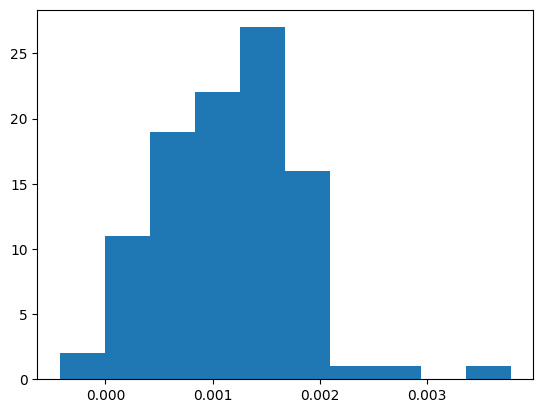

In [425]:
totoffs = np.array(totoffs)
plt.hist(totoffs[:, 2])
plt.show()

In [420]:
totoffs.s

[array([-0.02538528,  0.        ,  0.00378462]),
 array([-0.02025174,  0.        ,  0.0019447 ]),
 array([-0.02548598,  0.        ,  0.0004354 ]),
 array([-0.0240694 ,  0.        ,  0.00141747]),
 array([-0.01997117,  0.        ,  0.00026605]),
 array([-0.02444884,  0.        ,  0.00151188]),
 array([-0.0290767 ,  0.        ,  0.00070419]),
 array([-0.0217442 ,  0.        ,  0.00065482]),
 array([-0.02147706,  0.        ,  0.00087625]),
 array([-0.02460344,  0.        ,  0.00094113])]

Text(0.5, 0, 'iteration')

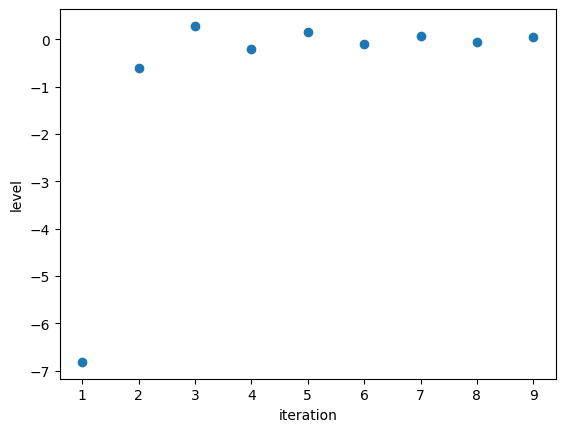

In [410]:
x = levels[:, 0]
x = x[x != 0]

plt.scatter(list(range(1, len(x) + 1)), x)
plt.ylabel('level')
plt.xlabel('iteration')

=============================SDSS vs 6dFGS=============================
Mean of epsilon = 0.018
Std of epsilon = 1.023
Comparisons = 332
Offset significance = 0.33
Error significance = 0.57
=============================SDSS vs LAMOST=============================
Mean of epsilon = 0.035
Std of epsilon = 1.093
Comparisons = 21395
Offset significance = 4.73
Error significance = 17.58
=============================6dFGS vs LAMOST=============================
Mean of epsilon = 0.353
Std of epsilon = 1.396
Comparisons = 97
Offset significance = 2.49
Error significance = 3.93


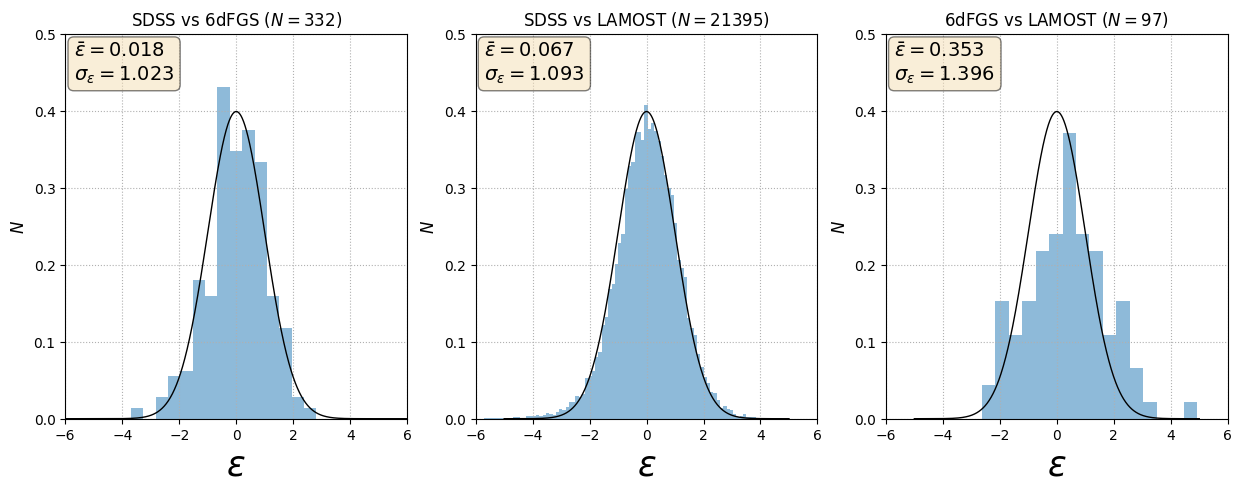

In [93]:
# Define the error scalings
k_sdss = 2.322
k_lamost = 1.666

# Define the offsets
Delta_6df = -0.024236101039486427
Delta_lamost = 0.0061588347531292854

# Read the file
df = pd.read_csv('data/processed/veldisp_calibrated/repeat_ori.csv')
# Apply the scalings and offsets
df['s_6df'] -= Delta_6df
df['s_lamost'] -= Delta_lamost
df['es_sdss'] *= k_sdss
df['es_lamost'] *= k_lamost

# Store the velocity dispersions and errors in a single array
sig = df[['s_sdss', 's_6df', 's_lamost']].to_numpy().T
dsig = df[['es_sdss', 'es_6df', 'es_lamost']].to_numpy().T

# plt.rcParams["mathtext.fontset"] = "cm"

# sigma clipping
sigma_clip = 7.5
# offset clipping
delta_clip = 100.


#--------------------------------- SDSS vs 6dFGS -------------------------------------------------------#
## The discrepancy between s
delta = sig[0,:]-sig[1,:]
## Exclude erroneous measurements whose discrepancies are greater than delta_clip
cut = np.absolute(delta)<=delta_clip
epsilon = delta[cut]/np.sqrt(dsig[0,:][cut]**2+dsig[1,:][cut]**2)
## Remove nan values
epsilon = epsilon[~np.isnan(epsilon)]
## Apply sigma clipping
epsilon = epsilon[np.absolute(epsilon)<5.]

print('=============================SDSS vs 6dFGS=============================')
print('Mean of epsilon = %.3f' % np.mean(epsilon))
print('Std of epsilon = %.3f' % np.std(epsilon))
print('Comparisons = %.0f' % len(epsilon))
off_sig = np.absolute(np.mean(epsilon))/(np.std(epsilon)/np.sqrt(len(epsilon)))
err_sig = np.absolute(1-np.std(epsilon))/(np.std(epsilon)/np.sqrt(2*len(epsilon)-2))
print('Offset significance = %.2f' % off_sig)
print('Error significance = %.2f' % err_sig)

plt.figure(figsize=(15,5))
plt.subplot(131)

n_bins = 15
plt.hist(epsilon,bins=n_bins,density=True,alpha=0.5)

x_model = np.linspace(-6,6,1000)
y_model = norm.pdf(x_model,0,1)

plt.plot(x_model,y_model,linewidth=1,color='k')
plt.grid(linestyle=':')
plt.title(r'SDSS vs 6dFGS ($N = $%.0f)' % len(epsilon))
plt.xlabel(r'$\epsilon$',fontsize=25)
# plt.xlim(-4,4)
plt.xlim(-6,6)

plt.ylim(0,0.5)
plt.ylabel(r'$N$',fontsize=12)
# plt.text(-3,0.5,r'$\bar{\epsilon} = $ %.2f' % np.mean(epsilon))
textstr = '\n'.join((
    r'$\bar{\epsilon}=%.3f$' % np.mean(epsilon),
    r'$\sigma_\epsilon=%.3f$' % np.std(epsilon)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-5.7, 0.49, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

#--------------------------------- SDSS vs LAMOST -------------------------------------------------------#
delta = sig[0,:]-sig[2,:]
cut = np.absolute(delta)<=delta_clip
epsilon = delta[cut]/np.sqrt(dsig[0,:][cut]**2+dsig[2,:][cut]**2)
epsilon = epsilon[~np.isnan(epsilon)]
epsilon = epsilon[np.absolute(epsilon)<sigma_clip]

print('=============================SDSS vs LAMOST=============================')
print('Mean of epsilon = %.3f' % np.mean(epsilon))
print('Std of epsilon = %.3f' % np.std(epsilon))
print('Comparisons = %.0f' % len(epsilon))
off_sig = np.absolute(np.mean(epsilon))/(np.std(epsilon)/np.sqrt(len(epsilon)))
err_sig = np.absolute(1-np.std(epsilon))/(np.std(epsilon)/np.sqrt(2*len(epsilon)-2))
print('Offset significance = %.2f' % off_sig)
print('Error significance = %.2f' % err_sig)

# plt.figure(figsize=(15,5))
# plt.subplot(131)

plt.subplot(132)

n_bins = 100
plt.hist(epsilon,bins=n_bins,density=True,alpha=0.5)

# fit with Gaussian
def gaus(x,mu,sig):
    return (1/np.sqrt(2*np.pi*sig**2))*np.exp(-0.5*((x-mu)/sig)**2)

y, x_edges = np.histogram(epsilon,bins=n_bins,density=True)
x = (x_edges[1:] + x_edges[:-1])/2
popt, pcov = curve_fit(gaus,x,y,p0=[0,1])
popt[1] = np.absolute(popt[1])

x_model = np.linspace(-5,5,1000)
y_model = norm.pdf(x_model,0,1)

plt.plot(x_model,y_model,linewidth=1,color='k')
plt.grid(linestyle=':')
plt.title(r'SDSS vs LAMOST ($N = $%.0f)' % len(epsilon))
plt.xlabel(r'$\epsilon$',fontsize=25)
plt.ylabel(r'$N$',fontsize=12)
# plt.xlim(-4,4)
plt.xlim(-6,6)
plt.ylim(0,0.5)

# textstr = '\n'.join((
#     r'$\bar{\epsilon}=%.3f$' % np.mean(epsilon),
#     r'$\sigma_\epsilon=%.3f$' % np.std(epsilon)))
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# plt.text(-3.8, 0.44, textstr, fontsize=14,
#         verticalalignment='top', bbox=props)

# Use the fitted Gaussian
textstr = '\n'.join((
    r'$\bar{\epsilon}=%.3f$' % popt[0],
    r'$\sigma_\epsilon=%.3f$' % np.std(epsilon)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-5.7,0.49, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

#--------------------------------- 6dFGS vs LAMOST -------------------------------------------------------#
epsilon = (sig[1,:]-sig[2,:])/np.sqrt(dsig[1,:]**2+dsig[2,:]**2)
epsilon = epsilon[~np.isnan(epsilon)]
epsilon = epsilon[epsilon<sigma_clip]

print('=============================6dFGS vs LAMOST=============================')
print('Mean of epsilon = %.3f' % np.mean(epsilon))
print('Std of epsilon = %.3f' % np.std(epsilon))
print('Comparisons = %.0f' % len(epsilon))
off_sig = np.absolute(np.mean(epsilon))/(np.std(epsilon)/np.sqrt(len(epsilon)))
err_sig = np.absolute(1-np.std(epsilon))/(np.std(epsilon)/np.sqrt(2*len(epsilon)-2))
print('Offset significance = %.2f' % off_sig)
print('Error significance = %.2f' % err_sig)

plt.subplot(133)

n_bins = 16
plt.hist(epsilon,bins=n_bins,density=True,alpha=0.5)

x_model = np.linspace(-5,5,1000)
y_model = norm.pdf(x_model,0,1)
plt.plot(x_model,y_model,linewidth=1,color='k')
plt.grid(linestyle=':')
plt.title(r'6dFGS vs LAMOST ($N = $%.0f)' % len(epsilon))
plt.xlabel(r'$\epsilon$',fontsize=25)
plt.ylabel(r'$N$',fontsize=12)
# plt.xlim(-4,4)
plt.xlim(-6,6)
plt.ylim(0,0.5)

textstr = '\n'.join((
    r'$\bar{\epsilon}=%.3f$' % np.mean(epsilon),
    r'$\sigma_\epsilon=%.3f$' % np.std(epsilon)))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(-5.7, 0.49, textstr, fontsize=14,
        verticalalignment='top', bbox=props)
# plt.savefig('../../images/epsilon_after.png',dpi=400, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [51]:
# Check uniqueness of raw data
with fits.open('data/raw/6dfgs/sdfgs_fp_vizier.fits') as hdul:
    df = Table(hdul[1].data).to_pandas()
print(f"Number of 6dFGS galaxies = {len(df)}. Uniqueness of raw 6dFGS = {df['_2MASX'].nunique() / len(df) * 100}")

df = pd.read_csv('data/raw/sdss/SDSS_spectro.csv')
print(f"Number of 6dFGS galaxies = {len(df)}. Uniqueness of raw SDSS = {df['objID'].nunique() / len(df) * 100}")

with fits.open('data/raw/lamost/lamost_DR7_VDcat_20200825.fits') as hdul:
    df = Table(hdul[1].data).to_pandas()
print(f"Number of LAMOST galaxies = {len(df)}. Uniqueness of raw SDSS = {df['obsid'].nunique() / len(df) * 100}")

print('\n')

# Check uniqueness of spectrophoto data
df = pd.read_csv('data/preprocessed/spectrophoto/6dfgs.csv')
print(f"Number of 6dFGS galaxies = {len(df)}. Uniqueness of raw 6dFGS = {df['_2MASX'].nunique() / len(df) * 100}")
df = pd.read_csv('data/preprocessed/spectrophoto/sdss.csv')
print(f"Number of SDSS galaxies = {len(df)}. Uniqueness of raw SDSS = {df['tmass'].nunique() / len(df) * 100}")


Number of 6dFGS galaxies = 11102. Uniqueness of raw 6dFGS = 100.0
Number of 6dFGS galaxies = 281711. Uniqueness of raw SDSS = 100.0
Number of LAMOST galaxies = 85861. Uniqueness of raw SDSS = 100.0


Number of 6dFGS galaxies = 11102. Uniqueness of raw 6dFGS = 100.0
Number of SDSS galaxies = 91175. Uniqueness of raw SDSS = 99.99122566493008


In [56]:
df = pd.read_csv('data/raw/2mass/sdss_tmass.csv', low_memory=False)
df = df[df.designation.notna()]
print(f"Number of SDSS galaxies = {len(df)}. Uniqueness of raw SDSS = {df['designation'].nunique() / len(df) * 100}")

Number of SDSS galaxies = 155621. Uniqueness of raw SDSS = 99.98522050365953


In [28]:
df = pd.read_csv('data/preprocessed/spectrophoto/lamost.csv')

df[df['z_lamost'] > 0.1]

,obsid,ra,dec,z_lamost,veldisp,veldisp_err,tmass,glon,glat,j_ba,...,log_r_h_smodel_h,log_r_h_model_h,fit_ok_h,log_r_h_app_k,log_r_h_smodel_k,log_r_h_model_k,fit_ok_k,tempel_counterpart,IDcl,zcl
11,8403109,121.591870,6.537230,0.145917,155.0,10.0,2MASXJ08062202+0632138,215.619,19.626,1.0,...,0.206,0.003,OK,0.363,0.363,0.167,OK,False,18785,0.10168
12,8403127,122.196880,6.555630,0.146207,226.0,17.0,2MASXJ08084721+0633199,215.887,20.172,1.0,...,0.323,0.130,OK,0.284,0.285,0.061,OK,True,18754,0.14705
14,8404157,122.699160,6.189530,0.294312,314.0,23.0,2MASXJ08104780+0611220,216.475,20.454,0.5,...,0.390,0.258,OK,0.454,0.436,0.320,OK,False,126,0.09873
16,8404197,122.783910,5.996560,0.153084,128.0,12.0,2MASXJ08110811+0559480,216.699,20.442,0.7,...,0.325,0.000,NOK,0.738,0.696,0.674,OK,False,2706,0.05070
17,8406103,125.266390,5.345520,0.129234,287.0,15.0,2MASXJ08210390+0520440,218.525,22.349,0.8,...,0.437,0.345,OK,0.311,0.311,0.120,OK,False,451,0.07940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62982,744004076,241.654375,4.941268,0.116241,360.0,25.0,2MASXJ16063707+0456281,16.391,38.563,0.7,...,0.403,0.249,OK,0.000,0.000,0.000,NOK,False,538,0.11665
62983,744004250,242.086590,5.456839,0.140165,256.0,16.0,2MASXJ16082077+0527245,17.239,38.458,0.5,...,0.492,0.378,OK,0.000,0.000,0.000,NOK,True,715,0.13961
62984,744006043,243.521583,5.382835,0.149578,294.0,18.0,2MASXJ16140514+0522580,18.074,37.189,0.8,...,0.524,0.435,OK,0.563,0.568,0.499,OK,True,944,0.14995
62991,746213012,227.314301,27.027955,0.119289,242.0,13.0,2MASXJ15091539+2701402,40.784,59.420,0.7,...,0.445,0.304,OK,0.410,0.407,0.240,OK,True,34444,0.12050


# CALCULATE MEAN TOTOFFS

6dFGS mean offset = -0.023864096905447642
6dFGS offset standard deviation = 0.004538394485890116
LAMOST mean offset = 0.00337597699059923
LAMOST offset standard deviation = 0.0006539341800931568


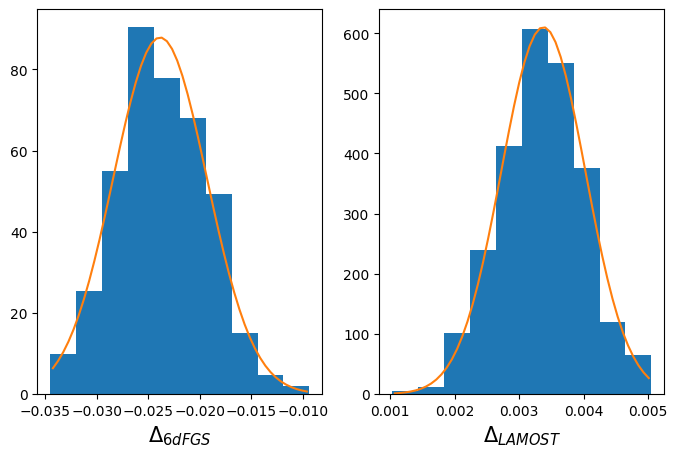

In [7]:
# Define gaussian function
def gaus(x, xmean, sigma):
    y = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-0.5 * ((x - xmean) / sigma)**2)
    return y

df = pd.read_csv('data/processed/veldisp_calibrated/totoffs.csv')

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=DEFAULT_FIGSIZE)

# Plot 6dFGS totoffs
off_6df = df.off_6df.to_numpy()

y, x_edges = np.histogram(off_6df, bins=50, density=True)
x = (x_edges[1:] + x_edges[:-1]) / 2
popt, pcov = curve_fit(gaus, x, y, p0=[np.mean(off_6df), np.std(off_6df)])
print(f'6dFGS mean offset = {popt[0]}')
print(f'6dFGS offset standard deviation = {popt[1]}')

ax1.hist(df.off_6df, bins=10, density=True)
ax1.plot(x, gaus(x, *popt))
ax1.set_xlabel(r'$\Delta_{6dFGS}$', fontsize=15)


# Plot LAMOST totoffs
off_lamost = df.off_lamost.to_numpy()

y, x_edges = np.histogram(off_lamost, bins=50, density=True)
x = (x_edges[1:] + x_edges[:-1]) / 2
popt, pcov = curve_fit(gaus, x, y, p0=[np.mean(off_lamost), np.std(off_lamost)])
print(f'LAMOST mean offset = {popt[0]}')
print(f'LAMOST offset standard deviation = {popt[1]}')

ax2.hist(df.off_lamost, bins=10, density=True)
ax2.plot(x, gaus(x, *popt))
ax2.set_xlabel(r'$\Delta_{LAMOST}$', fontsize=15)

plt.show()

# GENERATE BEFORE AND AFTER VELDISP CALIBRATION PLOT

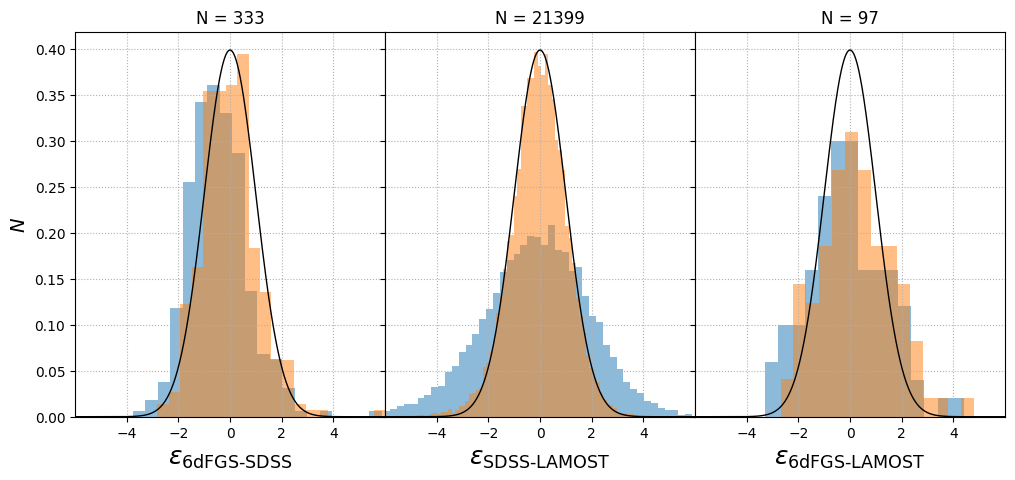

In [15]:
# # Previous results (5 sigma clipping)
k_sdss = 2.322
k_lamost = 1.666
off_6df = -0.024236101039486427
off_lamost = 0.0011588347531292854

# CONSTANTS
BIN_LIST = [20, 100, 15]
XLIM_LIST = [(-6, 6), (-6, 6), (-6, 6)]
XLABEL_LIST = [r'$\epsilon_\text{6dFGS-SDSS}$', r'$\epsilon_\text{SDSS-LAMOST}$', r'$\epsilon_\text{6dFGS-LAMOST}$']

df = pd.read_csv('data/processed/veldisp_calibrated/repeat_ori.csv')

# Apply the offsets
df['s_6df_scaled'] = df['s_6df'] - off_6df
df['es_6df_scaled'] = df['es_6df']
df['s_sdss_scaled'] = df['s_sdss']
df['es_sdss_scaled'] = df['es_sdss'] * k_sdss
df['s_lamost_scaled'] = df['s_lamost'] - off_lamost
df['es_lamost_scaled'] = df['es_lamost'] * k_lamost

# Calculate the epsilons (without offset)
df['epsilon_6df_sdss'] = (df['s_6df'] - df['s_sdss']) / np.sqrt(df['es_6df']**2 + df['es_sdss']**2)
df['epsilon_sdss_lamost'] = (df['s_sdss'] - df['s_lamost']) / np.sqrt(df['es_sdss']**2 + df['es_lamost']**2)
df['epsilon_6df_lamost'] = (df['s_6df'] - df['s_lamost']) / np.sqrt(df['es_6df']**2 + df['es_lamost']**2)
epsilon = df[['epsilon_6df_sdss', 'epsilon_sdss_lamost', 'epsilon_6df_lamost']]

# Calculate the epsilons (with offset)
df['epsilon_6df_sdss_scaled'] = (df['s_6df_scaled'] - df['s_sdss_scaled']) / np.sqrt(df['es_6df_scaled']**2 + df['es_sdss_scaled']**2)
df['epsilon_sdss_lamost_scaled'] = (df['s_sdss_scaled'] - df['s_lamost_scaled']) / np.sqrt(df['es_sdss_scaled']**2 + df['es_lamost_scaled']**2)
df['epsilon_6df_lamost_scaled'] = (df['s_6df_scaled'] - df['s_lamost_scaled']) / np.sqrt(df['es_6df_scaled']**2 + df['es_lamost_scaled']**2)
epsilon_scaled = df[['epsilon_6df_sdss_scaled', 'epsilon_sdss_lamost_scaled', 'epsilon_6df_lamost_scaled']]

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 5))
    
# Plot before and after scaling + offset
for i, ax in enumerate(axs):
    data = epsilon[epsilon.columns[i]].dropna()
    ax.hist(data, bins=BIN_LIST[i], density=True, alpha=0.5)
    
    data = epsilon_scaled[epsilon_scaled.columns[i]].dropna()
    ax.hist(data, bins=BIN_LIST[i], density=True, alpha=0.5)
    
    # Misc
    ax.grid(linestyle=":")
    ax.set_title(f'N = {len(data)}')
    ax.set_xlim(XLIM_LIST[i])
    ax.set_xlabel(XLABEL_LIST[i], fontsize=18)
    ax.set_xticks(ax.get_xticks()[1:-1])
    
    if i==0:
        ax.set_ylabel(r'$N$', fontsize=14)
    
# Plot standard normal Gaussians (target)
x = np.arange(start=-10., stop=10., step=0.0001)
y = norm.pdf(x, loc=0., scale=1.)
for ax in axs:
    ax.plot(x, y, c='k', lw=1.0)

plt.subplots_adjust(wspace=0)

plt.show()

# APPLY SELECTION CRITERIA

In [27]:
INPUT_FILEPATH = {
    '6dFGS': ('data/processed/veldisp_calibrated/6dfgs.csv'),
    'SDSS': ('data/processed/veldisp_calibrated/sdss.csv'),
    'LAMOST': ('data/processed/veldisp_calibrated/lamost.csv')
}

# Selection criteria constants
UPPER_Z_LIMIT = 16120.0 / LIGHTSPEED
LOWER_Z_LIMIT = 3000.0 / LIGHTSPEED
UPPER_MAG_LIMIT = 13.65
LOWER_VELDISP_LIMIT = np.log10(112)

for survey in SURVEY_LIST:
    df = pd.read_csv(INPUT_FILEPATH[survey])
    old_count = len(df)
    print(f"Original number of galaxies in {survey}: {old_count}")
    
    # Apply upper CMB redshift limit
    df = df[df['z_dist_est'] <= UPPER_Z_LIMIT]
    new_count = len(df)
    print(f"Number of galaxies after cz <= 16120 = {new_count} | Discarded galaxies = {old_count - new_count}")
    old_count = new_count
    
    # Apply upper magnitude limit
    df = df[(df['j_m_ext'] - df['extinction_j']) <= UPPER_MAG_LIMIT]
    new_count = len(df)
    print(f"Number of galaxies after (m_j - extinction_j) <= 13.65 = {new_count} | Discarded galaxies = {old_count - new_count}")
    old_count = new_count
    
    # Apply upper veldisp limit
    df = df[df['s_scaled'] >= LOWER_VELDISP_LIMIT]
    new_count = len(df)
    print(f"Number of galaxies after s_scaled >= log10(112) + 6dFGS_offset = {new_count} | Discarded galaxies = {old_count - new_count}")
    old_count = new_count
    
    # Apply lower CMB redshift limit
    df_high_z = df[df['z_dist_est'] >= LOWER_Z_LIMIT]
    new_count = len(df_high_z)
    print(f"Number of galaxies after cz >= 3000 = {new_count} | Discarded galaxies = {old_count - new_count}")
    
    # Save the remaining high-redshift galaxies
#     df_high_z.to_csv()
    
    # Save the low-redshift galaxies (will not be used to fit the FP due to high scatter but PVs will still be measured)
    df_low_z = df[df['z_dist_est'] <= LOWER_Z_LIMIT]
    print(f"Number of galaxies with cz <= 3000 = {len(df_low_z)}")
#     df_low_z.to_csv()

    print('\n')

Original number of galaxies in 6dFGS: 11102
Number of galaxies after cz <= 16120 = 10363 | Discarded galaxies = 739
Number of galaxies after (m_j - extinction_j) <= 13.65 = 9737 | Discarded galaxies = 626
Number of galaxies after s_scaled >= log10(112) + 6dFGS_offset = 9730 | Discarded galaxies = 7
Number of galaxies after cz >= 3000 = 9642 | Discarded galaxies = 88
Number of galaxies with cz <= 3000 = 88


Original number of galaxies in SDSS: 88955
Number of galaxies after cz <= 16120 = 24670 | Discarded galaxies = 64285
Number of galaxies after (m_j - extinction_j) <= 13.65 = 13142 | Discarded galaxies = 11528
Number of galaxies after s_scaled >= log10(112) + 6dFGS_offset = 11171 | Discarded galaxies = 1971
Number of galaxies after cz >= 3000 = 11154 | Discarded galaxies = 17
Number of galaxies with cz <= 3000 = 17


Original number of galaxies in LAMOST: 61693
Number of galaxies after cz <= 16120 = 12001 | Discarded galaxies = 49692
Number of galaxies after (m_j - extinction_j) <= 1

Index(['tmass', 'Jlogr', 'n', 'Hlogr', 'Klogr', '_6dFGS', 'ra', 'dec', 'cz',
       'Mt', 'Group', 'Nr', 'Ng', 'cz_gr', 'designation', 'glon', 'glat',
       'j_ba', 'h_ba', 'k_ba', 'sup_ba', 'r_ext', 'j_m_ext', 'h_m_ext',
       'k_m_ext', 'j_r_eff', 'h_r_eff', 'k_r_eff', 'MJD', 'z', 'S_N', 'Vd',
       'e_Vd', 'theta_j', 'theta_h', 'theta_k', 'z_cmb', 'z_dist_est',
       'sigma_corr', 'e_sigma_corr', 'extinction_j', 'extinction_h',
       'extinction_k', 'kcor_j', 'kcor_h', 'kcor_k', 'r_j', 'i_j', 'r_h',
       'i_h', 'r_k', 'i_k', 's', 'es', 's_scaled', 'es_scaled'],
      dtype='object')